# Project One Code 

## Econ 1680: MLTA and Econ

#### Name: Nadya Tan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Data Cleaning and Preparation

In [25]:
df_microdata = pd.read_csv('micro_world_139countries.csv', encoding='latin-1')

In [26]:
# select columns to keep 
selected = ['economycode', 'wgt','female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment', 'merchantpay_dig' ]
# new df 
df_selected = df_microdata[selected]

In [27]:
df_selected.shape

(143887, 32)

## One-hot Encoding 

In [28]:
# these variables need maps
# educ - change to 3 columns with 0-1 - if value is 4-5, put na in all 3 cols 
educ_dummies = pd.get_dummies(df_selected['educ'], prefix='educ').astype(int)
educ_dummies = educ_dummies.drop(columns=['educ_4', 'educ_5'])
# Fill NaN values for rows where educ was 4 or 5
educ_dummies.loc[df_selected['educ'].isin([4, 5]), :] = np.nan

# Convert inc_q to 5 columns
inc_q_dummies = pd.get_dummies(df_selected['inc_q'], prefix='inc_q').astype(int)
df_selected = pd.concat([df_selected, educ_dummies, inc_q_dummies], axis=1)

In [29]:
# Convert female to 0-1
df_selected['female'] = df_selected['female'].apply(lambda x: 1 if x == 1 else 0)

# Convert emp_in to 0-1
df_selected['emp_in'] = df_selected['emp_in'].apply(lambda x: 1 if x == 1 else 0)

# Convert urbanicity_f2f to 0-1
df_selected['urbanicity_f2f'] = df_selected['urbanicity_f2f'].apply(lambda x: 1 if x == 2 else 0)

In [30]:
# Convert these other financial variables to 0-1 and na for 3-4 
other_cols = [col for col in df_selected.columns if col in ['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a','mobileowner', 'internetaccess']]
for col in other_cols:
    df_selected[col] = df_selected[col].apply(lambda x: 1 if x == 1 else (0 if x == 2 else None))

In [31]:
# Replace old column with 0-1 
def replace_value(value):
    if value in [1, 2, 3]:
        return 1
    elif value == 4:
        return 0
    else:
        return np.nan  # NaN for values 5
columns_to_process = ['receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities']
for column in columns_to_process:
    df_selected[column] = df_selected[column].apply(replace_value)

In [32]:
def replace_value_remittances(value):
    if value in [1, 2, 3, 4]:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df_selected['remittances'] = df_selected['remittances'].apply(replace_value)

In [33]:
# economycode 
economycode_dummies = pd.get_dummies(df_selected['economycode']).astype(int)
df_selected = pd.concat([df_selected, economycode_dummies], axis=1)

In [34]:
df_selected.shape

(143887, 185)

In [35]:
df_selected.to_csv('microdata_cleaned.csv')

## Summary Statistics 

In [36]:
df_selected[['female', 'age', 'educ', 'inc_q', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'anydigpayment']].describe()

,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,account_fin,account_mob,saved,borrowed,receive_wages,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment
count,143887.000000,143420.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000,82706.000000,143887.000000,143887.000000,143114.000000,143067.000000,143298.000000,113897.000000,143145.000000,45438.000000,143750.000000,143296.000000,143887.000000
mean,0.532258,41.056889,1.968204,3.234239,0.643971,0.304843,0.708646,0.656001,0.260259,0.540563,0.525565,0.384421,0.193665,0.121097,0.134376,0.579545,0.917140,0.881357,0.704625,0.648856
std,0.498960,17.342777,0.723923,1.419803,0.478826,0.460343,0.454388,0.475042,0.438779,0.498354,0.499348,0.486460,0.395170,0.326241,0.341057,0.493634,0.275674,0.323370,0.456213,0.477329
min,0.000000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,38.000000,2.000000,3.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,54.000000,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,99.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
df_selected[['fin2', 'fin4', 'fin5', 'fin6', 'fin7', 'fin8', 'fin9', 'fin10', 'fin13a']].describe()

,fin2,fin4,fin5,fin6,fin7,fin8,fin9,fin10,fin13a
count,142816.000000,72811.000000,88782.000000,88807.000000,88619.000000,32569.000000,88556.000000,88534.000000,17634.000000
mean,0.510762,0.744214,0.585231,0.645636,0.368251,0.830391,0.786463,0.801760,0.741692
std,0.499886,0.436305,0.492685,0.478323,0.482333,0.375295,0.409806,0.398676,0.437717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# educ, economycode and income one hot encodes 
df_selected[['educ_1', 'educ_2', 'educ_3', 'inc_q_1', 'inc_q_2', 'inc_q_3', 'inc_q_4', 'inc_q_5']].describe()

,educ_1,educ_2,educ_3,inc_q_1,inc_q_2,inc_q_3,inc_q_4,inc_q_5
count,143132.000000,143132.000000,143132.000000,143887.000000,143887.000000,143887.000000,143887.000000,143887.000000
mean,0.269597,0.505834,0.224569,0.162301,0.172913,0.191442,0.214933,0.258411
std,0.443752,0.499968,0.417300,0.368728,0.378174,0.393437,0.410777,0.437763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Using Lasso and Ridge to Fine-Tune OLS


In [2]:
chosen_variables = ['age', 'female', 'educ_1', 'educ_2', 'educ_3', 'inc_q_1', 'inc_q_2', 'inc_q_3', 'inc_q_4', 'inc_q_5', 'account_fin', 'account_mob', 'receive_wages', 'mobileowner', 'internetaccess', 'pay_utilities', 'fin4', 'fin8', 'wgt']

In [3]:
df = pd.read_csv("microdata_cleaned.csv", index_col=0)

In [4]:
df_selected = df[chosen_variables].copy()

In [5]:
df_selected.dropna(inplace=True)

In [6]:
df_selected.shape

(6170, 19)

In [7]:
y=df_selected['account_mob']
X=df_selected.drop(columns=['account_mob', 'wgt', 'educ_1', 'inc_q_1'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680,stratify=y)

In [8]:
weights_train = df_selected.loc[X_train.index, 'wgt']

#### OLS Regression

In [9]:
ols_result = sm.OLS(y_train, X_train, weights=weights_train).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:            account_mob   R-squared:                      -0.119
Model:                            OLS   Adj. R-squared:                 -0.121
Method:                 Least Squares   F-statistic:                    -41.96
Date:                Mon, 06 May 2024   Prob (F-statistic):               1.00
Time:                        13:11:55   Log-Likelihood:                -3751.6
No. Observations:                5553   AIC:                             7533.
Df Residuals:                    5538   BIC:                             7633.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.0062      0.000    -12.

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\regression\linear_model.py:921: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


In [10]:
latex_results = ols_result.summary().as_latex()

print(latex_results)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   account\_mob   & \textbf{  R-squared:         } &    -0.119   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    -0.121   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    -41.96   \\
\textbf{Date:}             & Mon, 06 May 2024 & \textbf{  Prob (F-statistic):} &     1.00    \\
\textbf{Time:}             &     13:12:13     & \textbf{  Log-Likelihood:    } &   -3751.6   \\
\textbf{No. Observations:} &        5553      & \textbf{  AIC:               } &     7533.   \\
\textbf{Df Residuals:}     &        5538      & \textbf{  BIC:               } &     7633.   \\
\textbf{Df Model:}         &          14      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                        & \textbf{coef}

#### LASSO regression 

In [11]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=100)

# Construct vectors to store mean prediction errors and coefficients
cv_errs = []
coefs = []
MSE = float('inf')
best_lasso_alpha = 0

# Loop for running Lasso regression for different values of alpha
for a in alphas:
    # Define pipeline object
    lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=a))
    
    # Run Lasso regression
    lassoReg.fit(X_train, y_train, lasso__sample_weight=weights_train)
    
    # Obtain predicted values of output
    y_pred = lassoReg.predict(X_test)
    
    # Compute mean squared error
    cv_errs.append(mean_squared_error(y_test, y_pred))
    
    # Store coefficients
    coefs.append(lassoReg['lasso'].coef_)
    
    # Store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE:
        MSE = mean_squared_error(y_test, y_pred)
        best_lasso_alpha = a

print("Best Lasso Alpha:", best_lasso_alpha)

Best Lasso Alpha: 1e-06


Text(0, 0.5, 'Mean Squared Error')

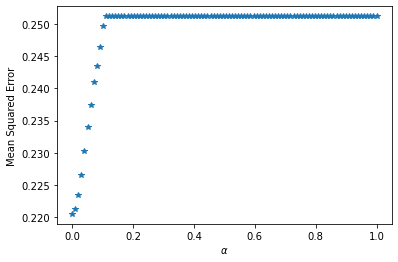

In [12]:
# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#### Ridge Regression - searching for optimal alpha 

In [13]:
# Construct vector of alpha values
alphas = np.linspace(1e-6, 1, num=100)

# Construct vectors to store mean prediction errors and coefficients
cv_errs = []
coefs = []
MSE = 10
best_ridge_alpha = 0

# Loop for running ridge regression for different values of alpha
for a in alphas:
    
    # define pipeline object
    ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    # run Ridge regression
    ridgeReg.fit(X_train, y_train, ridge__sample_weight=weights_train)
    # obtain predicted values of output
    y_pred = ridgeReg.predict(X_test)
    # compute mean squared error
    cv_errs.append(mean_squared_error(y_test, y_pred))
    # store coefficients
    coefs.append(ridgeReg['ridge'].coef_)
    
    # store value of alpha that minimizes the mean squared error
    if mean_squared_error(y_test, y_pred) < MSE: #np.mean((y_pred - y_test)**2)
        MSE = mean_squared_error(y_test, y_pred)
        best_ridge_alpha = a
        
print(best_ridge_alpha)
    
# Create dataframe for storing coefficients
coefs = pd.DataFrame(coefs, columns=X.columns)
coefs.set_index(alphas, inplace=True)

0.020203


Text(0, 0.5, 'Mean Squared Error')

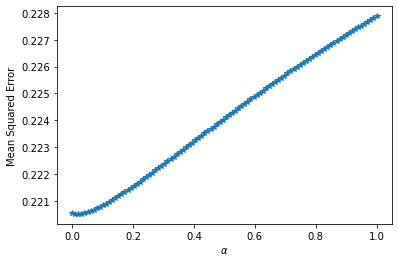

In [14]:
# Plot the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

#### Comparing Regression Outputs


In [15]:
alpha = best_lasso_alpha
lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= alpha * np.sqrt(X_train.shape[0])))
lassoReg.fit(X_train, y_train)

alpha = best_ridge_alpha
ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= alpha * np.sqrt(X_train.shape[0])))
ridgeReg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridge', Ridge(alpha=1.5054963279852263))])

In [16]:
coef_comp=pd.DataFrame({'var':X.columns, 'val_ols':ols_result.params.tolist(), 'val_lasso':lassoReg[-1].coef_, 'var_ridge':ridgeReg[-1].coef_})

In [17]:
print(coef_comp.to_markdown())


|    | var            |     val_ols |    val_lasso |    var_ridge |
|---:|:---------------|------------:|-------------:|-------------:|
|  0 | age            | -0.0061553  | -0.0847396   | -0.0848378   |
|  1 | female         | -0.00179864 | -0.000842385 | -0.000894747 |
|  2 | educ_2         | -0.0195752  | -0.00914412  | -0.00974109  |
|  3 | educ_3         | -0.0446631  | -0.0213385   | -0.0219848   |
|  4 | inc_q_2        | -0.0158144  | -0.00512133  | -0.00494409  |
|  5 | inc_q_3        |  0.0351851  |  0.0118781   |  0.0122193   |
|  6 | inc_q_4        |  0.0641043  |  0.0263891   |  0.0267905   |
|  7 | inc_q_5        |  0.105754   |  0.0520004   |  0.0524639   |
|  8 | account_fin    |  0.320836   |  0           |  0           |
|  9 | receive_wages  |  0.148609   |  0.0728875   |  0.0729074   |
| 10 | mobileowner    |  0.0319314  |  0.00459476  |  0.00468036  |
| 11 | internetaccess |  0.071777   |  0.0210055   |  0.0211036   |
| 12 | pay_utilities  |  0.0923539  |  0.0407881

In [18]:
print(coef_comp.to_latex())

\begin{tabular}{llrrr}
\toprule
 & var & val_ols & val_lasso & var_ridge \\
\midrule
0 & age & -0.006155 & -0.084740 & -0.084838 \\
1 & female & -0.001799 & -0.000842 & -0.000895 \\
2 & educ_2 & -0.019575 & -0.009144 & -0.009741 \\
3 & educ_3 & -0.044663 & -0.021339 & -0.021985 \\
4 & inc_q_2 & -0.015814 & -0.005121 & -0.004944 \\
5 & inc_q_3 & 0.035185 & 0.011878 & 0.012219 \\
6 & inc_q_4 & 0.064104 & 0.026389 & 0.026790 \\
7 & inc_q_5 & 0.105754 & 0.052000 & 0.052464 \\
8 & account_fin & 0.320836 & 0.000000 & 0.000000 \\
9 & receive_wages & 0.148609 & 0.072887 & 0.072907 \\
10 & mobileowner & 0.031931 & 0.004595 & 0.004680 \\
11 & internetaccess & 0.071777 & 0.021005 & 0.021104 \\
12 & pay_utilities & 0.092354 & 0.040788 & 0.040840 \\
13 & fin4 & 0.087599 & 0.037199 & 0.037271 \\
14 & fin8 & 0.072039 & 0.029127 & 0.029170 \\
\bottomrule
\end{tabular}



### Use findings to refine OLS model and test accuracy

In [9]:
y=df_selected['account_mob']
X=df_selected.drop(columns=['account_mob', 'wgt', 'educ_1', 'inc_q_1','account_fin'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680,stratify=y)

In [10]:
weights_train = df_selected.loc[X_train.index, 'wgt']

In [11]:
ols_result = sm.OLS(y_train, X_train, weights=weights_train).fit()
print(ols_result.summary())

                                 OLS Regression Results                                
Dep. Variable:            account_mob   R-squared (uncentered):                   0.534
Model:                            OLS   Adj. R-squared (uncentered):              0.533
Method:                 Least Squares   F-statistic:                              453.2
Date:                Mon, 06 May 2024   Prob (F-statistic):                        0.00
Time:                        15:39:28   Log-Likelihood:                         -3769.0
No. Observations:                5553   AIC:                                      7566.
Df Residuals:                    5539   BIC:                                      7659.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\regression\linear_model.py:921: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


In [22]:
latex_results = ols_result.summary().as_latex()

print(latex_results)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   account\_mob   & \textbf{  R-squared (uncentered):}      &     0.534   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared (uncentered):} &     0.533   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       }          &     453.2   \\
\textbf{Date:}             & Mon, 06 May 2024 & \textbf{  Prob (F-statistic):}          &     0.00    \\
\textbf{Time:}             &     13:13:15     & \textbf{  Log-Likelihood:    }          &   -3769.0   \\
\textbf{No. Observations:} &        5553      & \textbf{  AIC:               }          &     7566.   \\
\textbf{Df Residuals:}     &        5539      & \textbf{  BIC:               }          &     7659.   \\
\textbf{Df Model:}         &          14      & \textbf{                     }          &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     }          &             \\
\bottomru

In [13]:
y_pred = ols_result.predict(X_test)

# Binarize the predicted values (assuming a threshold of 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Binarize the actual values
y_test_binary = (y_test >= 0.5).astype(int)

# Calculate accuracy
accuracy = (y_pred_binary == y_test_binary).mean()
print("Accuracy of OLS Regression:", accuracy)

Accuracy of OLS Regression: 0.6499189627228525


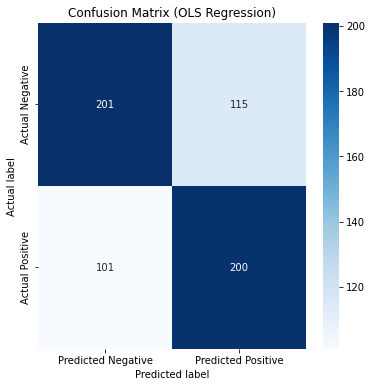

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix (OLS Regression)')
plt.show()


# Trying Non-Linear Models: Hist Gradient Boost

In [2]:
chosen_variables = ['female', 'age', 'emp_in', 'urbanicity_f2f', 'account', 'account_fin', 'account_mob', 'saved', 'borrowed', 'receive_wages', 'receive_transfers', 'receive_pension', 'receive_agriculture', 'pay_utilities', 'remittances', 'mobileowner', 'internetaccess', 'fin2', 'fin4', 'fin7', 'fin8', 'fin9', 'fin10', 'educ_1', 'educ_2', 'educ_3', 'inc_q_1', 'inc_q_2', 'inc_q_3', 'inc_q_4', 'inc_q_5', 'wgt']

In [3]:
df = pd.read_csv("microdata_cleaned.csv", index_col=0)

In [4]:
df_selected = df[chosen_variables].copy()

In [5]:
df_selected.dropna(subset=['account_mob'], inplace=True)

In [6]:
y=df_selected['account_mob']
X=df_selected.drop(columns=['account_mob', 'wgt', 'educ_1', 'inc_q_1'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1680,stratify=y)

In [7]:
weights_train = df_selected.loc[X_train.index, 'wgt']

In [8]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

C:\Users\Nadya\anaconda3\envs\ECON1680\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [9]:
# Initialize HistGradientBoostingClassifier
hist_gb_classifier = HistGradientBoostingClassifier()

# Train the model
hist_gb_classifier.fit(X_train, y_train, sample_weight=weights_train)

# Predict on the test set
hist_gb_predictions = hist_gb_classifier.predict(X_test)

# Calculate accuracy
hist_gb_accuracy = accuracy_score(y_test, hist_gb_predictions)
print("HistGradientBoosting Classifier Accuracy:", hist_gb_accuracy)


HistGradientBoosting Classifier Accuracy: 0.8694232861806311


In [12]:
from sklearn.inspection import permutation_importance

# Define your feature names
feature_names = X.columns

# run permutation importance
result = permutation_importance(hist_gb_classifier, X_test, y_test, n_repeats=20, random_state=1680, n_jobs=-1)

# Get sorted feature importances by absolute value
sorted_idx = np.argsort(np.abs(result.importances_mean))[::-1]

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Importance': result.importances_mean[sorted_idx]
})

# Convert DataFrame to LaTeX table
latex_table = feature_importance_df.to_latex(index=False)

print(latex_table)


\begin{tabular}{lr}
\toprule
Feature & Importance \\
\midrule
account & 0.296306 \\
account_fin & 0.128050 \\
remittances & 0.017815 \\
age & 0.007291 \\
saved & 0.005284 \\
receive_transfers & 0.002763 \\
receive_agriculture & 0.002394 \\
inc_q_5 & 0.002194 \\
internetaccess & 0.001487 \\
fin4 & 0.001384 \\
receive_wages & 0.001354 \\
fin10 & 0.001203 \\
emp_in & 0.001191 \\
female & 0.001167 \\
fin9 & 0.000895 \\
inc_q_3 & -0.000858 \\
educ_3 & 0.000768 \\
pay_utilities & 0.000550 \\
inc_q_4 & -0.000369 \\
borrowed & 0.000320 \\
urbanicity_f2f & 0.000254 \\
mobileowner & 0.000218 \\
fin8 & 0.000206 \\
receive_pension & -0.000157 \\
fin2 & 0.000036 \\
educ_2 & -0.000030 \\
fin7 & -0.000018 \\
inc_q_2 & -0.000006 \\
\bottomrule
\end{tabular}



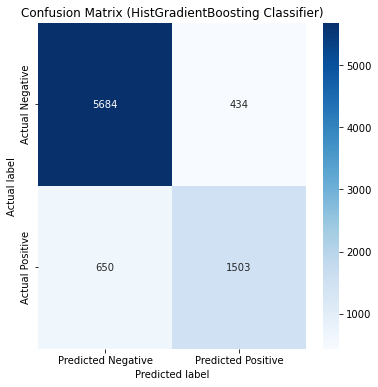

In [35]:
# Create confusion matrix
conf_matrix_gb = confusion_matrix(y_test, hist_gb_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gb, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix (HistGradientBoosting Classifier)')
plt.show()
